# EECS 531 - A1
### Tristan Maidment (tdm47)
### Assignment 1

#### Exercise 2

To solve this exercise, I use the same imports as before.

In [1]:
%matplotlib inline
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import numpy as np

I also use the `convolve` function defined in Exerise 1.

In [2]:
def convolve(img, kernel):
    kernel = np.flip(np.flip(kernel, 1), 0) #rotate the kernel 180 degrees
    
    width, height, channels = img.shape 
    k_width, k_height = kernel.shape
    
    k_half_width = math.floor(k_width/2)
    k_half_width_2 = math.ceil(k_width/2)
    k_half_height = math.floor(k_height/2)
    k_half_height_2 = math.ceil(k_height/2)
        
    ret = np.zeros(img.shape) 
    
    img_pad = np.zeros((width + k_width + 1 , height + k_width + 1, channels))
    img_pad[k_half_width : -k_half_width_2 - 1,
            k_half_height : -k_half_height_2 - 1] = img 
    
    for x in range(width):
        for y in range(height):
            for c in range(channels):
                ret[x, y, c] = np.multiply(kernel, img_pad[x: x + k_width, 
                                                            y  : y + k_height,
                                                            c]).sum()
    return ret/ret.max()

I then load the image used for edge detection.  I am using the example image from the Wikipedia Sobel operator page:
https://en.wikipedia.org/wiki/Sobel_operator

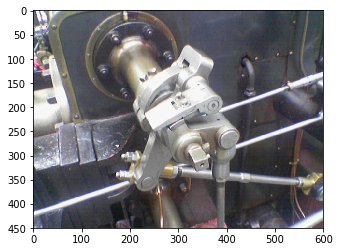

In [18]:
img = cv2.imread('./sobel.png', 1)
if img is not None:
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
plt.imshow(img)
plt.show()

To see the proper output for Canny edge detection, I ran the built in function in OpenCV.  My goal for the exercise is to implement Canny edge detection from scratch.

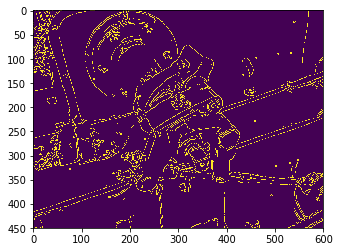

In [5]:
edge = cv2.Canny(img, 100, 200)
plt.imshow(edge)
plt.show()

The first step is to apply a Gaussian blur.  I am using the same kernel as defined in Exercise 1.  This step removes noise which improves edge detection.

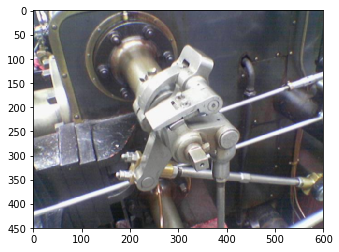

In [6]:
gaussian_3 = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16
denoised = convolve(img, gaussian_3)
plt.imshow(denoised)
plt.show()

The next step is to apply the Sobel operator in the X direction.  This kernel is approximates the gradient along that axis, and should provides the edge intensity along the X direction.

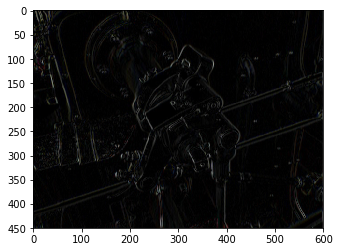

In [7]:
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) * 1/8
g_x = convolve(denoised, sobel_x)
plt.imshow(np.absolute(g_x)) # can't graph negative values since RGB specification is float from 0-1
plt.show()

The next step is to apply the Sobel operator in the Y direction.  Similarly to the previous step, this approximates the intensity of the angles along the Y axis.

It's interesting to note that the Sobel operator matrix sums to 0, lowering the intensity of every channel.  That is why the output image appears to be black.

The value of the angles can be negative at this point.  Since pyplot only supports floats from the range `0. - 1.`, I graph the absolute value of the plot.

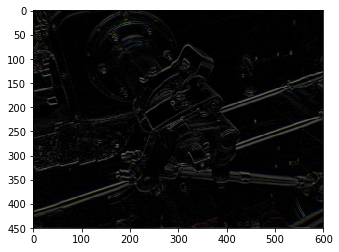

In [8]:
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) * 1/8
g_y = convolve(denoised, sobel_y)
plt.imshow(np.absolute(g_y))
plt.show()

The next step is to find the angle and intensity of the overall gradient.  In order to determine the angle of the gradient at every point, we run an element-wise arctan on the two gradients.  This provides the angle at which the edge occurs.

In addition, we can calculate the intensity of the gradient by taking the square root of the sum of the squared X and Y gradients.

In [9]:
g = np.sqrt(np.power(g_x, 2) + np.power(g_y, 2))
angle = np.arctan2(g_y, g_x)

We know can see the intensity of the gradients in both directions.  It clearly outlines the edges of the image.

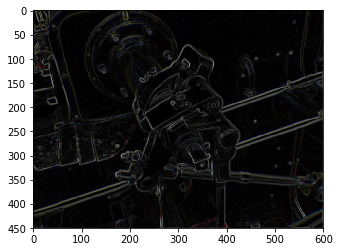

In [10]:
plt.imshow(g/g.max())
plt.show()
# sobel operator output

In addition, we can somewhat see the angle of the edges by normalizing the angles between `0. - 1.`.  This should provide a limited visual representation of the gradient angles.

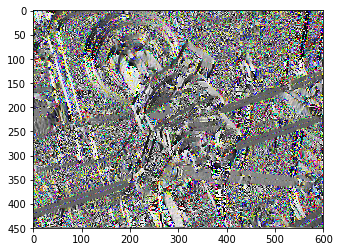

In [19]:
plt.imshow(np.absolute(angle/angle.max()))
plt.show()

Next, I want to see the range of angles that we have to consider.  To do so, I plot a histogram of the gradient angles (of the red spectrum only, but it should give a representation of the overall picture).  We can see that the angles range from _-pi_ to _+pi_. 

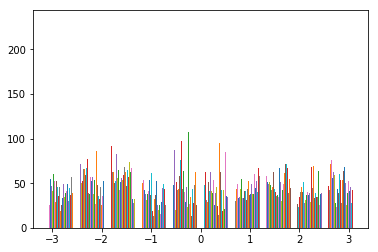

In [12]:
plt.hist(angle[:,:,0])
plt.show()

We can simplify the classification processes by recognizing that all negative angles correspond with angles on the positive side.  To do so, I shift all the angles by _pi_ degrees, and take the modulus of the result.  This should provide angles from _0_ to _+pi_ degrees without loss of information.

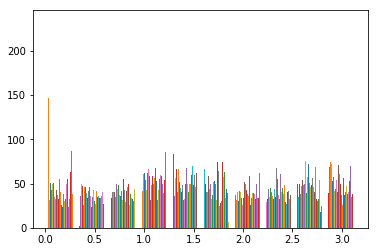

In [13]:
angle = np.mod((angle + np.pi), np.pi) #convert to 180 degrees
plt.hist(angle[:,:,0])
plt.show()

The next step is called "Non-Maximal Suppression". The idea behind this step is to ensure that only local maximums of the gradient are kept.  This should reflect the true location of the edge and removes extraneous information.  We execute this idea by selecting every point and looking at the angle of the gradient.  The edge is normal to the angle, so we select points accordingly.  By comparing the intensities of each point, we can determine if the edge is maximal or not.

The numbers in this function are the radian equavalents to 22.5, 157.5, 67.5, and 112.5 degrees.  These angles are the edges of the 45, 90, and 135 quadrants, and are used as classifiers for which pixels to be comparing.

In [14]:
def non_max_supp(gradient, angles):
    ret = np.zeros_like(gradient)
    
    width, height, channels = img.shape
    
    for x in range(1,width-1):
        for y in range(1,height-1):
            for c in range(channels):
                theta = angles[x, y, c]
                intensity = gradient[x, y, c]
                # in RADIANS
                if theta >= 2.7488936 or theta < 0.3926991:
                    #check left and right
                    intensity = supp_val(intensity, gradient[x + 1, y, c], gradient[x - 1, y, c])
                elif theta >= 0.3926991 and theta < 1.178097:
                    #check top right and bottom left
                    intensity = supp_val(intensity, gradient[x + 1, y + 1, c], gradient[x - 1, y - 1, c])
                elif theta >= 1.178097 and theta < 1.9634954:
                    #check top and bottom
                    intensity = supp_val(intensity, gradient[x, y + 1, c], gradient[x, y - 1, c])
                elif theta >= 1.9634954 and theta < 2.7488936:
                    #check top left and bottom right
                    intensity = supp_val(intensity, gradient[x + 1, y - 1, c], gradient[x - 1, y + 1, c])
                ret[x, y, c] = intensity
    return ret

# returns the correct value for suppressed pixel
# if A is a local maximum, the value is returned, otherwise it is removed.
def supp_val(A, B, C):
    if A > B and A > C:
        return A
    return 0.

After running this function, we can see that a decent amount of non-edge boundaries were removed.  Unfortunately, due to the decrease in active pixels, the image is visibly darker.

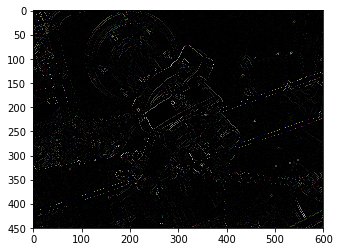

In [15]:
angle_supp = non_max_supp(g, angle)
plt.imshow(angle_supp/angle_supp.max())
plt.show()

The next step is to apply `hysterisis` on the image, which takes two thresholds.  These two thresholds are defined when running the built in Canny function.  To explain simply, the first threshold defines value required to be automatically kept in the final image.  The second threshold is the limit required for pixels adjacent to a pixel being kept in the image, including pixels that are kept above this second threshold.  This is to define continuous edges that don't have gaps in between them.

In [16]:
def hysterisis(supp, t1, t2):
    ret = np.zeros_like(supp)
    
    width, height, channels = supp.shape
    
    for x in range(1,width-1):
        for y in range(1,height-1):
            for c in range(channels):
                theta = supp[x, y, c]
                if theta < t2:
                    ret[x, y, c] = theta
    return ret

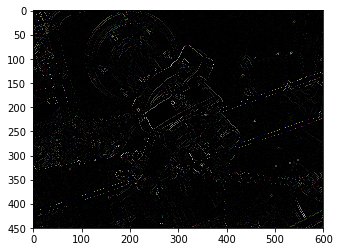

In [17]:
hyst = hysterisis(angle_supp, 3, 1.57)
plt.imshow(hyst / hyst.max())
plt.show()